In [47]:
import DataLoading
from torch.utils.data import DataLoader,TensorDataset
import torch
import pandas as pd
import NN_classes
import training_methods
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
sc = "sc01"
period = "2030"
folder = "../Data/RTS24_AC_12w"
all_executions = DataLoading.list_executions(folder="../Data/RTS24_AC_12w",per = period,sc=sc)
executions = all_executions[1:20]
te_s = 0.3
val_s = 0.4

In [29]:
dfs_in,dfs_out = DataLoading.load_data(folder,executions,period,sc)

input_f_sc01_Network_Line_In_N_101_N_102_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_103_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_101_N_105_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_104_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_102_N_106_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_103_N_124_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_104_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_105_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_106_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_107_N_108_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_109_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_108_N_110_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_111_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_109_N_112_cac1_2030.csv
1227
input_f_sc01_Network_Line_In_N_110_N_111

In [30]:
ts_in,ts_out =  DataLoading.split_tr_val_te_by_exec(dfs_in,dfs_out,executions,te_s,val_s,False)

In [31]:
d_ft_in, d_ft_out = DataLoading.concat_and_normalize_split_by_exec(ts_in,ts_out,executions)

In [32]:
train = TensorDataset(d_ft_in['train'].float(), d_ft_out['train'].float())
validation = TensorDataset(d_ft_in['val'].float(), d_ft_out['val'].float())

training_loader = DataLoader(train,batch_size=64)
validation_loader = DataLoader(train,batch_size=64)

In [34]:
learning_rates = [0.01*4**i for i in range(2)]
loss_fn = torch.nn.MSELoss()
nbs_e = [4,8,12]#,4,8]
i=0
nbs_hidden = [0,1,2,3]
dors = [0,0.1,0.2,0.4]
results = pd.DataFrame()
folder_to_save = "RTS24_AC_12w_split_by_exec"
for nb_e in nbs_e:
    for lr in learning_rates:
        for nb_hidden in nbs_hidden: 
            for dor in dors:
                m = NN_classes.create_model(nb_hidden,d_ft_in['train'].shape[1],dropout_ratio= dor)
                m_name = f"OE_{nb_hidden}h_{nb_e}e_{lr}lr_{dor}dor"
                optimizer = torch.optim.Adam(m.parameters(), lr=lr)
                train_loss = training_methods.train_multiple_epochs(nb_e,m,training_loader,validation_loader,loss_fn,optimizer,m_name,folder_to_save)

                saved_models = dict()

                for mt in ["min_val","all_epochs"]:
                    path = f"trained_models/{folder_to_save}/{mt}/model_{m_name}.pth"


                    model = m
                    m.load_state_dict(torch.load(path))
                    m.eval()

                    test_predictions = m(d_ft_in["test"].float())
                    test_loss = loss_fn(test_predictions,d_ft_out["test"])

                    train_predictions = m(d_ft_in["train"].float())
                    train_loss = loss_fn(train_predictions,d_ft_out["train"])

                    validation_prediction = m(d_ft_in["val"].float())
                    validation_loss = loss_fn(validation_prediction,d_ft_out["val"])

                    if mt == "min_val": 
                        min_val = True
                    else: 
                        min_val = False

                    r = pd.DataFrame({"Model_type": nb_hidden,
                                      "Min_val":min_val,
                                      "Epochs": nb_e,
                                      "Lr":lr,
                                      "Dor": dor,
                                      "Tr_l":train_loss.item(),
                                      "Te_l":test_loss.item(),
                                      "V_l": validation_loss.item()}
                                     ,index = [i]
                    )
                    i+=1
                    results = pd.concat([results,r])

ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0, inplace=False)
) 0 0
EPOCH 1:
  batch 1 loss: 1.2201406061649322e-05
  batch 101 loss: 0.1204996619992744
  batch 201 loss: 0.000164767281494278


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


LOSS train 0.044235667404096846 valid 0.0006014840328134596
EPOCH 2:
  batch 1 loss: 4.681292630266398e-06
  batch 101 loss: 0.00027236131966674294
  batch 201 loss: 5.8436349319208604e-05
LOSS train 0.00015514195799257586 valid 0.0004910084535367787
EPOCH 3:
  batch 1 loss: 4.016830353066325e-06
  batch 101 loss: 0.0003662908967976364
  batch 201 loss: 8.31776264385553e-05
LOSS train 0.0002038881896868798 valid 0.000458039139630273
EPOCH 4:
  batch 1 loss: 3.595936286728829e-06
  batch 101 loss: 0.00039822076774726156
  batch 201 loss: 6.36935441548303e-05
LOSS train 0.00021898659113981595 valid 0.0004524539690464735


C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([13104])) that is different to the input size (torch.Size([13104, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([17472])) that is different to the input size (torch.Size([17472, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Workdir\Programs\Miniconda\envs\jr23\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([10920])) that is different to the input size (torch.Size([10920, 1])). This will likely lead to incorrect results due to broadca

ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 0.1 0
EPOCH 1:
  batch 1 loss: 7.842912338674069e-05
  batch 101 loss: 0.13347931323805823
  batch 201 loss: 0.002807125097606331
LOSS train 0.05038690856477116 valid 0.00041876404429785907
EPOCH 2:
  batch 1 loss: 2.8133392333984375e-05
  batch 101 loss: 0.0008269710635067895
  batch 201 loss: 0.00022606664686463773
LOSS train 0.0004243751014995384 valid 0.00012009174679405987
EPOCH 3:
  batch 1 loss: 7.5960688991472126e-06
  batch 101 loss: 0.00010940661964923492
  batch 201 loss: 2.719192711992946e-05
LOSS train 6.075725839151353e-05 valid 5.878495721844956e-05
EPOCH 4:
  batch 1 loss: 2.139530988642946e-06
  batch 101 loss: 5.7172719693880935e-05
  batch 201 loss: 1.177490160898742e-05
LOSS train 2.941249779110883e-05 valid 4.8474139475729316e-05
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_fea

  batch 101 loss: 0.00019000596203113673
  batch 201 loss: 0.00013505661194358255
LOSS train 0.00015400555913325435 valid 7.367978105321527e-05
EPOCH 3:
  batch 1 loss: 1.1021287355106325e-06
  batch 101 loss: 0.00012213259427767297
  batch 201 loss: 0.00012192503999926885
LOSS train 0.0001236395805707093 valid 8.334748417837545e-05
EPOCH 4:
  batch 1 loss: 1.086812699213624e-06
  batch 101 loss: 0.0001261923332779702
  batch 201 loss: 0.00012584170262016413
LOSS train 0.0001270724631205455 valid 6.312463665381074e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.2 2
EPOCH 1:
  batch 1 loss: 0.0018054090440273284
  batch 101 loss: 0.007987159964686725
  batch 201 loss: 0.00011507962760333612
LOSS train 0.003650819112151975 valid 6.357369420584

  batch 101 loss: 2.068170643961057
  batch 201 loss: 0.0034442438988480715
LOSS train 0.7593842358488313 valid 0.0006835560780018568
EPOCH 2:
  batch 1 loss: 3.964441828429699e-05
  batch 101 loss: 0.0014922003669198603
  batch 201 loss: 0.00028178602704429065
LOSS train 0.0006966298963664989 valid 0.000156109977979213
EPOCH 3:
  batch 1 loss: 7.04960897564888e-06
  batch 101 loss: 0.0002035056574277405
  batch 201 loss: 3.3468968094894084e-05
LOSS train 9.620181785126928e-05 valid 6.190537533257157e-05
EPOCH 4:
  batch 1 loss: 2.1522796305362135e-06
  batch 101 loss: 5.427309221886389e-05
  batch 201 loss: 1.0212623108145635e-05
LOSS train 2.780900790756464e-05 valid 4.944560714648105e-05
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 0.2 0
EPOCH 1:
  batch 1 loss: 0.0001669972576200962
  batch 101 loss: 2.1592801195615903
  batch 201 loss: 0.005864059365121648
LOSS train 0.793511

  batch 201 loss: 0.00013759143761490122
LOSS train 0.00013936785842735925 valid 6.617492181248963e-05
EPOCH 4:
  batch 1 loss: 6.660519284196198e-07
  batch 101 loss: 0.00013007119352550944
  batch 201 loss: 0.00011858509716603294
LOSS train 0.00012077170364359901 valid 5.4972959333099425e-05
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.2 2
EPOCH 1:
  batch 1 loss: 0.0002482319995760918
  batch 101 loss: 0.006259977708518249
  batch 201 loss: 5.872825686310534e-05
LOSS train 0.0024221436691105225 valid 0.00026192437508143485
EPOCH 2:
  batch 1 loss: 1.022042488330044e-06
  batch 101 loss: 7.86624223758281e-05
  batch 201 loss: 7.96614667956419e-05
LOSS train 7.595197100368957e-05 valid 0.00012197132309665903
EPOCH 3:
  batch 1 loss: 1.681508

  batch 201 loss: 0.0004220076109686488
LOSS train 0.0007383210025535189 valid 0.0076264250092208385
EPOCH 8:
  batch 1 loss: 6.126614287495613e-05
  batch 101 loss: 0.005813717785276822
  batch 201 loss: 0.002739353307551937
LOSS train 0.003493415190783481 valid 0.0007842782069928944
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 0.1 0
EPOCH 1:
  batch 1 loss: 0.00020502842962741852
  batch 101 loss: 0.1221977606555447
  batch 201 loss: 0.0021654399612452834
LOSS train 0.04592895457024717 valid 0.00036676801391877234
EPOCH 2:
  batch 1 loss: 2.4269525893032552e-05
  batch 101 loss: 0.0005868093221215532
  batch 201 loss: 0.0001904364452639129
LOSS train 0.00031476114366878156 valid 6.278957880567759e-05
EPOCH 3:
  batch 1 loss: 3.3001130213961006e-06
  batch 101 loss: 8.136010092130164e-05
  batch 201 loss: 3.073086875701847e-05
LOSS train 4.766137141444603e-05 valid 4.811884718947

  batch 101 loss: 0.00012747332387618826
  batch 201 loss: 0.00012274335186049257
LOSS train 0.00012426508941210479 valid 5.252940172795206e-05
EPOCH 7:
  batch 1 loss: 3.43146275554318e-07
  batch 101 loss: 0.00011667837732602493
  batch 201 loss: 0.00010796486740446199
LOSS train 0.0001093865891352551 valid 5.702579801436514e-05
EPOCH 8:
  batch 1 loss: 5.156923634785926e-08
  batch 101 loss: 9.79391593224932e-05
  batch 201 loss: 8.935127851998459e-05
LOSS train 9.028198898036886e-05 valid 8.058959065238014e-05
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.2 1
EPOCH 1:
  batch 1 loss: 0.00024804677814245225
  batch 101 loss: 0.03833682917786064
  batch 201 loss: 6.589913213247201e-05
LOSS train 0.014174272413837015 valid 5.464059722726233e-05
EPOCH 2:
  batch 1 loss: 4.2294996092095973e-07
  batch 101 loss:

LOSS train 8.351734803186562e-05 valid 7.282599835889414e-05
EPOCH 3:
  batch 1 loss: 8.661238098284229e-07
  batch 101 loss: 9.587495406549352e-05
  batch 201 loss: 0.00010203541521264014
LOSS train 0.00010191190146697708 valid 8.732950664125383e-05
EPOCH 4:
  batch 1 loss: 1.1182294110767543e-06
  batch 101 loss: 0.00011412436910774205
  batch 201 loss: 0.00011885908896260843
LOSS train 0.00011947741331040738 valid 8.455332863377407e-05
EPOCH 5:
  batch 1 loss: 1.0754338291008025e-06
  batch 101 loss: 0.0001267965970481555
  batch 201 loss: 0.0001258317705242007
LOSS train 0.0001271514010804472 valid 6.208179547684267e-05
EPOCH 6:
  batch 1 loss: 6.332184420898557e-07
  batch 101 loss: 0.0001244379297645537
  batch 201 loss: 0.00011731095075901976
LOSS train 0.000118773010656666 valid 5.108189725433476e-05
EPOCH 7:
  batch 1 loss: 1.7241687601199372e-07
  batch 101 loss: 0.0001080851615802203
  batch 201 loss: 9.905441777391388e-05
LOSS train 0.00010018543083298518 valid 6.7220913479

LOSS train 0.0001235260692485995 valid 8.253420674009249e-05
EPOCH 7:
  batch 1 loss: 1.0373212717240677e-06
  batch 101 loss: 0.00012751277901429603
  batch 201 loss: 0.00012597205497968388
LOSS train 0.0001274965553681459 valid 6.306612340267748e-05
EPOCH 8:
  batch 1 loss: 6.520455644931645e-07
  batch 101 loss: 0.0001255284621674946
  batch 201 loss: 0.00011879177147875453
LOSS train 0.00012069139230141032 valid 5.0908718549180776e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.4 3
EPOCH 1:
  batch 1 loss: 8.945577777922154e-05
  batch 101 loss: 0.03160964928742033
  batch 201 loss: 0.00015487190370549797
LOSS train 0.011688517035102554 valid 5.334504021448083e-05


  batch 101 loss: 3.083325987518038e-05
  batch 201 loss: 7.535587589700298e-05
LOSS train 6.404100419882731e-05 valid 7.09845990058966e-05
EPOCH 6:
  batch 1 loss: 2.3261551177711225e-07
  batch 101 loss: 0.0002074639517468313
  batch 201 loss: 0.00010262495570714236
LOSS train 0.00016891150865846143 valid 0.0003463896573521197
EPOCH 7:
  batch 1 loss: 4.812049446627498e-06
  batch 101 loss: 0.0009300298967355047
  batch 201 loss: 0.029301492460654117
LOSS train 0.04322436464093159 valid 0.004470854997634888
EPOCH 8:
  batch 1 loss: 0.0002052071690559387
  batch 101 loss: 0.03237874728627503
  batch 201 loss: 0.050294546234654264
LOSS train 0.06282293359235598 valid 0.021980617195367813
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0 1
EPOCH 1:
  batch 1 loss: 6.754414644092322e-06
  batch 101 loss: 0.36940280455

  batch 201 loss: 1.2949302217748481e-05
LOSS train 1.2296886260238743e-05 valid 3.715752609423362e-05
EPOCH 3:
  batch 1 loss: 7.781999556755182e-08
  batch 101 loss: 9.931604835173857e-06
  batch 201 loss: 8.751768283445927e-06
LOSS train 9.016155252958504e-06 valid 4.5295826566871256e-05
EPOCH 4:
  batch 1 loss: 8.75420312240749e-09
  batch 101 loss: 9.661372308755744e-06
  batch 201 loss: 8.243928097613208e-06
LOSS train 8.274050744619958e-06 valid 4.458242983673699e-05
EPOCH 5:
  batch 1 loss: 5.78544131712988e-09
  batch 101 loss: 6.599591160920681e-06
  batch 201 loss: 5.444953927167262e-06
LOSS train 5.782667765146764e-06 valid 3.562312849680893e-05
EPOCH 6:
  batch 1 loss: 3.1942774967319564e-08
  batch 101 loss: 5.465732712082172e-06
  batch 201 loss: 4.311632754507855e-06
LOSS train 4.4199243593984585e-06 valid 3.588771869544871e-05
EPOCH 7:
  batch 1 loss: 3.7165054891374897e-08
  batch 101 loss: 3.299787882866667e-06
  batch 201 loss: 2.493220315216149e-06
LOSS train 2.678

  batch 101 loss: 6.175273862822906e-05
  batch 201 loss: 1.7019835735254673e-05
LOSS train 3.623223654195056e-05 valid 5.4236490541370586e-05
EPOCH 8:
  batch 1 loss: 1.4300478142104113e-07
  batch 101 loss: 6.22360089130325e-05
  batch 201 loss: 1.5488677152575293e-05
LOSS train 3.587745462859707e-05 valid 6.618660700041801e-05
ObjectiveEstimator_ANN_3hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=306, bias=True)
  (hidden_layer2): Linear(in_features=306, out_features=76, bias=True)
  (hidden_layer3): Linear(in_features=76, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=19, out_features=1, bias=True)
) 0.1 3
EPOCH 1:
  batch 1 loss: 5.148256896063686e-06
  batch 101 loss: 10.358172689634376
  batch 201 loss: 0.0019099908822681755
LOSS train 3.795230326992515 valid 0.000266718037892133
EPOCH 2:
  batch 1 loss: 7.162774563767016e-06
  batch 101 loss: 0.0007448823406593874
  batch 201 loss: 0.0003909871

  batch 101 loss: 0.007695616839855575
  batch 201 loss: 0.0004670085366933563
LOSS train 0.0033610089520905457 valid 0.0023009609431028366
ObjectiveEstimator_ANN_Single_layer(
  (output_layer): Linear(in_features=1227, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
) 0.1 0
EPOCH 1:
  batch 1 loss: 0.0010063230991363525
  batch 101 loss: 0.08987513329600916
  batch 201 loss: 0.002150022409041412
LOSS train 0.034404536443310464 valid 0.00035498623037710786
EPOCH 2:
  batch 1 loss: 9.615075541660189e-06
  batch 101 loss: 0.00043769797674030996
  batch 201 loss: 0.00014206510222720682
LOSS train 0.00022997154376956536 valid 4.606762377079576e-05
EPOCH 3:
  batch 1 loss: 1.0921589273493736e-06
  batch 101 loss: 5.523698167962721e-05
  batch 201 loss: 2.221172930603643e-05
LOSS train 3.3264780697355645e-05 valid 3.479792212601751e-05
EPOCH 4:
  batch 1 loss: 4.386148793855682e-07
  batch 101 loss: 2.9084424784286967e-05
  batch 201 loss: 1.418862354285011e-05
LOSS tra

  batch 101 loss: 0.00011426729264968572
  batch 201 loss: 0.00011894064445357344
LOSS train 0.0001195532805525923 valid 8.490047184750438e-05
EPOCH 5:
  batch 1 loss: 1.0741391452029347e-06
  batch 101 loss: 0.00012687785948003238
  batch 201 loss: 0.00012584431600885183
LOSS train 0.00012713588240399992 valid 6.189411215018481e-05
EPOCH 6:
  batch 1 loss: 6.190208659972996e-07
  batch 101 loss: 0.00012426215155755926
  batch 201 loss: 0.00011706447790629681
LOSS train 0.00011859227230484349 valid 5.119460911373608e-05
EPOCH 7:
  batch 1 loss: 1.653146136959549e-07
  batch 101 loss: 0.00010802532163097567
  batch 201 loss: 9.874639254462635e-05
LOSS train 9.998659568665285e-05 valid 6.77059288136661e-05
EPOCH 8:
  batch 1 loss: 1.3068075759292696e-08
  batch 101 loss: 8.849224851360304e-05
  batch 201 loss: 8.083556611381936e-05
LOSS train 8.148462830788395e-05 valid 9.453186794416979e-05
EPOCH 9:
  batch 1 loss: 5.708317075914238e-08
  batch 101 loss: 7.298811974123964e-05
  batch 20

  batch 101 loss: 0.00012370574376973308
  batch 201 loss: 0.00011689790777836606
LOSS train 0.00011844820476190619 valid 5.103911098558456e-05
EPOCH 9:
  batch 1 loss: 1.7845615730038844e-07
  batch 101 loss: 0.00010911946917531168
  batch 201 loss: 0.00010045422936627802
LOSS train 0.0001016553440296522 valid 6.458539428422228e-05
EPOCH 10:
  batch 1 loss: 1.7660734101809793e-08
  batch 101 loss: 9.105795039317855e-05
  batch 201 loss: 8.347775013135106e-05
LOSS train 8.413930422256815e-05 valid 8.926468581194058e-05
EPOCH 11:
  batch 1 loss: 4.123934559174813e-08
  batch 101 loss: 7.56733596608683e-05
  batch 201 loss: 7.035622553758003e-05
LOSS train 7.049700803481056e-05 valid 0.00011347328108968213
EPOCH 12:
  batch 1 loss: 1.2971477190149016e-07
  batch 101 loss: 6.512896463618745e-05
  batch 201 loss: 6.201495214895658e-05
LOSS train 6.174875222860221e-05 valid 0.0001346473436569795
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=3

  batch 101 loss: 7.715112943060376e-05
  batch 201 loss: 7.961713856161624e-05
LOSS train 7.874041442881626e-05 valid 0.0002937106182798743
EPOCH 12:
  batch 1 loss: 1.2454135867301374e-06
  batch 101 loss: 7.994523454158298e-05
  batch 201 loss: 8.189391531800539e-05
LOSS train 8.12638192494291e-05 valid 0.00029815506422892213
ObjectiveEstimator_ANN_2hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (hidden_layer2): Linear(in_features=35, out_features=5, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (output_layer): Linear(in_features=5, out_features=1, bias=True)
) 0.4 2
EPOCH 1:
  batch 1 loss: 0.0002766587398946285
  batch 101 loss: 0.011868406652829434
  batch 201 loss: 9.470570023040637e-05
LOSS train 0.00450702856525969 valid 7.747139898128808e-05
EPOCH 2:
  batch 1 loss: 9.119478636421263e-07
  batch 101 loss: 9.913743332845115e-05
  batch 201 loss: 0.00010877453375570667
LOSS train 0.00010849970087990966 valid 8.829414582578465e-

  batch 101 loss: 0.01143297815022379
  batch 201 loss: 7.744907601590967e-05
LOSS train 0.004241265774207799 valid 6.889502401463687e-05
EPOCH 2:
  batch 1 loss: 7.719018321949989e-07
  batch 101 loss: 9.153170809213407e-05
  batch 201 loss: 0.0001017242881613356
LOSS train 0.00010090133705472621 valid 8.873915066942573e-05
EPOCH 3:
  batch 1 loss: 1.141195825766772e-06
  batch 101 loss: 0.00011893616281952291
  batch 201 loss: 0.00012322632041275483
LOSS train 0.0001236383845701848 valid 7.383197225863114e-05
EPOCH 4:
  batch 1 loss: 8.701873593963683e-07
  batch 101 loss: 0.00012760800517639837
  batch 201 loss: 0.0001218610117098251
LOSS train 0.0001231901006154398 valid 5.107840115670115e-05
EPOCH 5:
  batch 1 loss: 2.5316010578535495e-07
  batch 101 loss: 0.00011230387306795819
  batch 201 loss: 0.00010188903402649885
LOSS train 0.000103340044128488 valid 6.587195093743503e-05
EPOCH 6:
  batch 1 loss: 1.5318846635636874e-08
  batch 101 loss: 8.952655581992986e-05
  batch 201 loss

  batch 201 loss: 1.6018755757158943e-05
LOSS train 2.5429186625876018e-05 valid 0.000109668260847684
EPOCH 6:
  batch 1 loss: 4.221195194986649e-07
  batch 101 loss: 0.00015001977616975636
  batch 201 loss: 0.08579301306478555
LOSS train 0.03745153220310612 valid 0.009497628547251225
EPOCH 7:
  batch 1 loss: 0.00014410888776183127
  batch 101 loss: 0.04058735890605021
  batch 201 loss: 0.03529457074240781
LOSS train 0.05329498363447277 valid 0.03009737841784954
EPOCH 8:
  batch 1 loss: 0.0001309318281710148
  batch 101 loss: 0.013485376791504678
  batch 201 loss: 0.04894211988925235
LOSS train 0.032512990987668626 valid 0.010824299417436123
EPOCH 9:
  batch 1 loss: 0.00010677406564354896
  batch 101 loss: 0.019682666161097585
  batch 201 loss: 0.06495142323314212
LOSS train 0.04218061956459308 valid 0.0024594382848590612
EPOCH 10:
  batch 1 loss: 1.8111338140442966e-05
  batch 101 loss: 0.01735317029757425
  batch 201 loss: 0.07661161647411063
LOSS train 0.044020070907601835 valid 0.0

LOSS train 7.668031002508325e-05 valid 0.0001045828394126147
EPOCH 11:
  batch 1 loss: 9.302949365519452e-08
  batch 101 loss: 6.834545452875317e-05
  batch 201 loss: 6.393455745069331e-05
LOSS train 6.392678109404564e-05 valid 0.00013094954192638397
EPOCH 12:
  batch 1 loss: 2.1169218598515726e-07
  batch 101 loss: 5.987150969076538e-05
  batch 201 loss: 5.810333234990139e-05
LOSS train 5.765125604930024e-05 valid 0.00015604372310917825
ObjectiveEstimator_ANN_1hidden_layer(
  (hidden_layer1): Linear(in_features=1227, out_features=35, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=35, out_features=1, bias=True)
) 0.1 1
EPOCH 1:
  batch 1 loss: 3.975206986069679e-05
  batch 101 loss: 0.6276981451077154
  batch 201 loss: 0.0014881703379796818
LOSS train 0.23058246802474136 valid 5.738278923672624e-05
EPOCH 2:
  batch 1 loss: 4.540033478406258e-07
  batch 101 loss: 9.004825910778891e-05
  batch 201 loss: 5.358379016001891e-05
LOSS train 7.257719

  batch 101 loss: 0.13973410888762372
  batch 201 loss: 8.837426318223152e-05
LOSS train 0.05131885459041559 valid 0.00026260490994900465
EPOCH 2:
  batch 1 loss: 9.623418736737222e-07
  batch 101 loss: 8.751079408739315e-05
  batch 201 loss: 9.578612236964546e-05
LOSS train 9.334003153199797e-05 valid 0.0003506291832309216
EPOCH 3:
  batch 1 loss: 1.6286569007206708e-06
  batch 101 loss: 9.714218056046775e-05
  batch 201 loss: 9.549067665716393e-05
LOSS train 9.457637007961658e-05 valid 0.00030963061726652086
EPOCH 4:
  batch 1 loss: 1.3607642904389649e-06
  batch 101 loss: 8.362075108948374e-05
  batch 201 loss: 7.85936366213491e-05
LOSS train 7.860290869213727e-05 valid 0.0002356536715524271
EPOCH 5:
  batch 1 loss: 8.580177382100373e-07
  batch 101 loss: 6.898847722595747e-05
  batch 201 loss: 6.572047134454806e-05
LOSS train 6.552115164537006e-05 valid 0.00018898191046901047
EPOCH 6:
  batch 1 loss: 5.592594243353233e-07
  batch 101 loss: 6.0861633219246866e-05
  batch 201 loss: 5

  batch 101 loss: 6.0608400631281256e-05
  batch 201 loss: 5.781710102269244e-05
LOSS train 5.774978187665367e-05 valid 0.00016550417058169842
EPOCH 5:
  batch 1 loss: 3.99868113163393e-07
  batch 101 loss: 5.75780289557315e-05
  batch 201 loss: 5.9682957545419416e-05
LOSS train 5.8783374944198176e-05 valid 0.0002173544926336035
EPOCH 6:
  batch 1 loss: 7.217855454655364e-07
  batch 101 loss: 6.535071500252343e-05
  batch 201 loss: 7.112877873623802e-05
LOSS train 6.978019612708502e-05 valid 0.00028447527438402176
EPOCH 7:
  batch 1 loss: 1.1798417835962027e-06
  batch 101 loss: 7.928371625894215e-05
  batch 201 loss: 8.34526031542282e-05
LOSS train 8.257586709313038e-05 valid 0.000269810640020296
EPOCH 8:
  batch 1 loss: 1.0768328502308577e-06
  batch 101 loss: 8.088320460046816e-05
  batch 201 loss: 7.408763060993806e-05
LOSS train 7.557291895291168e-05 valid 0.0001529936125734821
EPOCH 9:
  batch 1 loss: 3.285710045020096e-07
  batch 101 loss: 6.072115439337722e-05
  batch 201 loss:

  batch 101 loss: 5.9481837361090584e-05
  batch 201 loss: 5.972065642708912e-05
LOSS train 5.903922021135815e-05 valid 5.121896538184956e-05
EPOCH 7:
  batch 1 loss: 3.548643144313246e-07
  batch 101 loss: 6.012015606756904e-05
  batch 201 loss: 6.740633729805267e-05
LOSS train 6.332520027441845e-05 valid 5.2249786676838994e-05
EPOCH 8:
  batch 1 loss: 3.8674421375617386e-07
  batch 101 loss: 6.384558218996972e-05
  batch 201 loss: 6.38876283483114e-05
LOSS train 6.330566292233879e-05 valid 5.310184133122675e-05
EPOCH 9:
  batch 1 loss: 4.0759710827842356e-07
  batch 101 loss: 6.468939818660147e-05
  batch 201 loss: 6.539474267810874e-05
LOSS train 6.472953306674687e-05 valid 5.375801629270427e-05
EPOCH 10:
  batch 1 loss: 4.415856528794393e-07
  batch 101 loss: 6.67111423535971e-05
  batch 201 loss: 6.772647379875707e-05
LOSS train 6.697509877914934e-05 valid 5.483796849148348e-05
EPOCH 11:
  batch 1 loss: 4.852208803640679e-07
  batch 101 loss: 6.898730760894978e-05
  batch 201 loss

In [62]:
results.to_csv("Loss_results_csv/20Exec_split_by_exec.csv")

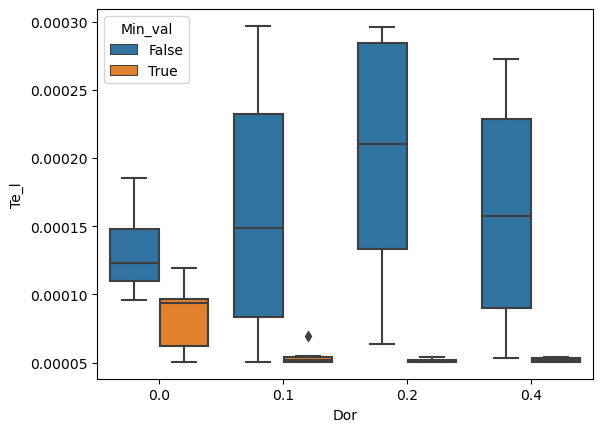

In [48]:
f = (results.Epochs == 12)  & (results.Model_type != 0) 
sns.boxplot(y = "Te_l",x="Dor",data = results[f],hue = "Min_val")
plt.savefig("Figures/Split_by_exec/Min_val_effect_Testloss_fDor.png")

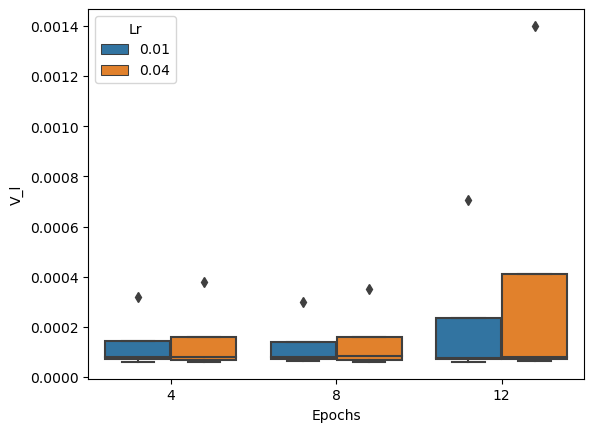

In [61]:
f =  (results.Model_type == 0) & (results.Min_val == True)
sns.boxplot(y = "V_l",x="Epochs",data = results[f],hue = "Lr")
plt.savefig("Figures/Split_by_exec/Lr_effect_Testloss_fEpochs.png")